In [1]:
!pip install torcheval

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from torcheval.metrics.functional import peak_signal_noise_ratio

from sklearn.model_selection import train_test_split

#### Load dataset

In [3]:
dataset_path = '/kaggle/input/dog-breed-image-dataset-256x256/dogs'

classes = {
    idx: cls for idx, cls in enumerate(sorted(os.listdir(dataset_path)))
}

print(classes)

{0: 'Bulldog', 1: 'Chihuahua', 2: 'GoldenRetreiver'}


In [4]:
dataset = []
for idx, cls in classes.items():
    class_dir = os.path.join(dataset_path, cls)
    data = []
    for idx, img_name in enumerate(os.listdir(class_dir)):
        img_path = os.path.join(class_dir, img_name)
        data.append(img_path)
        if idx >= 499: 
            break
    dataset.extend(data)
len(dataset)

1500

#### Chia train, val, test

In [5]:
test_size = 0.125
val_size = 0.2

train_dataset, val_dataset = train_test_split(
    dataset,
    test_size=val_size,
    shuffle=True,
    random_state=42
)

train_dataset, test_dataset = train_test_split(
    train_dataset,
    test_size=test_size,
    shuffle=True,
    random_state=42
)

In [6]:
train_dataset[0]

'/kaggle/input/dog-breed-image-dataset-256x256/dogs/Bulldog/J7N0MKCU2P36.jpg'

In [7]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1050
300
150


#### Datasets, DataLoader

In [8]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

class AnimalImageDataset(Dataset):
    def __init__(self, dataset, is_train=False):
        self.dataset = dataset
        self.is_train = is_train

    def __len__(self):
        return len(self.dataset)

    def normalize(self, input_image, target_image):
        input_image = input_image*2 - 1
        target_image = target_image*2 - 1
        return input_image, target_image

    def random_jitter(self ,input_image, target_image):
        if torch.rand([]) < 0.5: 
            input_image = transforms.functional.hflip(input_image)
            target_image = transforms.functional.hflip(target_image)
        return input_image, target_image
    
    def create_mask(self, image):
        masked_image = image.copy()
        mask = np.full((IMG_WIDTH, IMG_HEIGHT, 3), 0, np.uint8)
        for _ in range(np.random.randint(1, 5)):
            # Get random x locations to start line
            x1, x2 = np.random.randint(1, IMG_WIDTH), np.random.randint(1, IMG_WIDTH)
            # Get random y locations to start line
            y1, y2 = np.random.randint(1, IMG_HEIGHT), np.random.randint(1, IMG_HEIGHT)

            # Get random thickness of the line drawn
            thickness = np.random.randint(1, 15)
            # Draw line on the black mask
            cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)
        masked_image = np.where(mask, 255*np.ones_like(mask), masked_image)
        return masked_image

    def __getitem__(self, index):
        img_path = self.dataset[index]
        image = np.array(Image.open(img_path).convert('RGB'))

        # resize input image to 64x64
        input_image = self.create_mask(image)
        input_image = transforms.functional.to_tensor(input_image)
        input_image = input_image.type(torch.float32)
        
        # resize target image to 224x224
        target_image = transforms.functional.to_tensor(image)
        target_image = target_image.type(torch.float32)

        # normalize input_image, target_image
        input_image, target_image = self.normalize(input_image, target_image)

        if self.is_train:
            input_image, target_image = self.random_jitter(input_image, target_image)

        return input_image, target_image

In [9]:
train_animal_dataset = AnimalImageDataset(
    train_dataset,
    is_train=True
)
val_animal_dataset = AnimalImageDataset(
    val_dataset,
    is_train=False
)
test_animal_dataset = AnimalImageDataset(
    test_dataset,
    is_train=False
)

train_batch_size = 16
test_batch_size = 16
train_dataloader = DataLoader(
    train_animal_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_dataloader = DataLoader(
    val_animal_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_dataloader = DataLoader(
    test_animal_dataset,
    batch_size=test_batch_size,
    shuffle=True
)

In [10]:
import matplotlib.pyplot as plt

train_features = next(iter(train_dataloader))
input_image, target_image = train_features

In [11]:
input_image[0].shape

torch.Size([3, 256, 256])

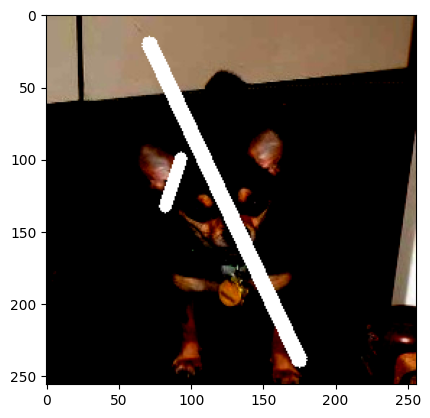

In [12]:
plt.imshow((input_image[0].permute((1, 2, 0))*255).type(torch.int64))

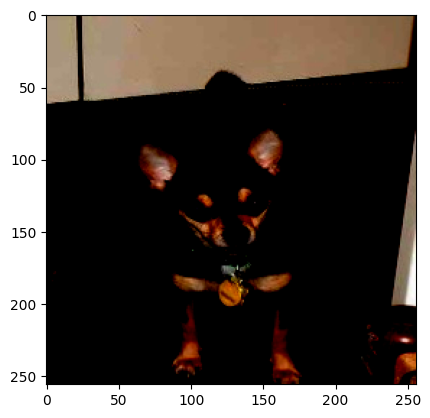

In [13]:
plt.imshow((target_image[0].permute((1, 2, 0))*255).type(torch.int64))

#### Hàm train, evaluate

In [14]:
def evaluate(model, criterion, val_loader, device):
    model.eval()
    total_psnr, total_count = 0, 0
    losses = []
    with torch.no_grad():
        for img_inputs, img_targets in val_loader:
            img_inputs, img_targets = img_inputs.to(device), img_targets.to(device)
            
            predicts = model(img_inputs)
            
            loss = criterion(predicts, img_targets)
            losses.append(loss.item())

            total_psnr += peak_signal_noise_ratio(predicts, img_targets)
            total_count += 1
    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [15]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs, device, file_save_model, log_interval=50):
    train_losses = []
    val_losses = []
    
    train_psnrs = []
    val_psnrs = []

    for epoch in range(epochs):
        batch_train_loss = []

        model.train()
        total_psnr, total_count = 0, 0
        for idx, (img_inputs, img_targets) in enumerate(train_loader):
            img_inputs, img_targets = img_inputs.to(device), img_targets.to(device)

            optimizer.zero_grad()
            img_predicts = model(img_inputs)
            
            # loss
            loss = criterion(img_predicts, img_targets)
            loss.backward()

            # backward
            optimizer.step()
            batch_train_loss.append(loss.item())

            total_psnr += peak_signal_noise_ratio(img_predicts, img_targets)
            total_count += 1

        epoch_train_psnr = total_psnr / total_count
        train_loss = sum(batch_train_loss) / len(batch_train_loss)
        train_losses.append(train_loss)
        train_psnrs.append(epoch_train_psnr)
        
        epoch_val_psnr, epoch_val_loss = evaluate(model, criterion, val_loader, device)
        val_losses.append(epoch_val_loss)
        val_psnrs.append(epoch_val_psnr)
        print(f'Epoch {epoch + 1}:\tTrain Loss: {train_loss:.4f}\tTrain PSNR:{epoch_train_psnr:.4f}\tVal Loss: {epoch_val_loss:.4f}\tVal PSRN:{epoch_val_psnr:.4f}')

    # save model
    torch.save(model.state_dict(), file_save_model)
    
    return train_losses, train_psnrs, val_losses, val_psnrs

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Model UNet with Skip Connection

In [17]:
class FirstFeature(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class FeatureOut(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            # vì input range đang ở khoảng [-1, 1], nếu input range ở khoảng [0, 1] thì dùng hàm sigmoid
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_sample = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        up_sample = self.up_sample(x)
        concat = torch.concat([up_sample, skip], dim=1)
        return self.conv_block(concat)


class UNetArchitecture(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.first_feature = FirstFeature(in_channels, 64)
        self.conv = ConvBlock(64, 64)

        self.encoder1 = Encoder(64, 128)
        self.encoder2 = Encoder(128, 256)
        self.encoder3 = Encoder(256, 512)
        self.encoder4 = Encoder(512, 1024)

        self.decoder1 = Decoder(1024, 512)
        self.decoder2 = Decoder(512, 256)
        self.decoder3 = Decoder(256, 128)
        self.decoder4 = Decoder(128, 64)

        self.out_conv = FeatureOut(64, n_classes)

    def forward(self, x):
        x = self.first_feature(x)
        x1 = self.conv(x)

        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x4 = self.encoder3(x3)
        x5 = self.encoder4(x4)

        x = self.decoder1(x5, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)
        x = self.out_conv(x)

        return x

In [18]:
unet_model = UNetArchitecture(
    in_channels=3,
    n_classes=3,
)

# run parallel cuda if number of cuda > 1
# if torch.cuda.device_count() > 1:
#     unet_model = nn.DataParallel(unet_model)
unet_model.to(device)

UNetArchitecture(
  (first_feature): FirstFeature(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (conv): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (encoder1): Encoder(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddin

In [19]:
epochs = 100
lr = 1e-3
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=lr)

In [20]:
train_losses_skip, train_psnrs_skip, val_losses_skip, val_psnrs_skip = train(
    model=unet_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    epochs=epochs,
    device=device,
    file_save_model='image_inpainting_skip_connection_last.pt'
)

Epoch 1:	Train Loss: 0.1335	Train PSNR:20.6203	Val Loss: 0.1057	Val PSRN:19.6176
Epoch 2:	Train Loss: 0.1042	Train PSNR:22.2305	Val Loss: 0.0783	Val PSRN:24.2591
Epoch 3:	Train Loss: 0.0851	Train PSNR:24.1201	Val Loss: 0.0966	Val PSRN:20.2137
Epoch 4:	Train Loss: 0.0834	Train PSNR:24.1231	Val Loss: 0.0794	Val PSRN:24.6266
Epoch 5:	Train Loss: 0.0776	Train PSNR:25.0457	Val Loss: 0.0680	Val PSRN:25.6403
Epoch 6:	Train Loss: 0.0705	Train PSNR:25.5816	Val Loss: 0.0604	Val PSRN:25.7422
Epoch 7:	Train Loss: 0.0660	Train PSNR:26.0042	Val Loss: 0.0401	Val PSRN:28.6174
Epoch 8:	Train Loss: 0.0679	Train PSNR:25.7102	Val Loss: 0.0478	Val PSRN:26.2285
Epoch 9:	Train Loss: 0.0609	Train PSNR:26.4427	Val Loss: 0.0476	Val PSRN:28.3969
Epoch 10:	Train Loss: 0.0613	Train PSNR:26.7016	Val Loss: 0.0413	Val PSRN:27.1638
Epoch 11:	Train Loss: 0.0640	Train PSNR:25.6705	Val Loss: 0.0511	Val PSRN:25.6792
Epoch 12:	Train Loss: 0.0589	Train PSNR:26.7796	Val Loss: 0.0528	Val PSRN:26.8921
Epoch 13:	Train Loss: 0.0

In [21]:
val_loss = evaluate(unet_model, criterion, val_dataloader, device)
test_loss = evaluate(unet_model, criterion, test_dataloader, device)
print(f'Valis Loss: {val_loss}')
print(f'Test Loss: {test_loss}')

Valis Loss: (tensor(32.3663, device='cuda:0'), 0.02108032099510494)
Test Loss: (tensor(33.1174, device='cuda:0'), 0.020308989100158215)


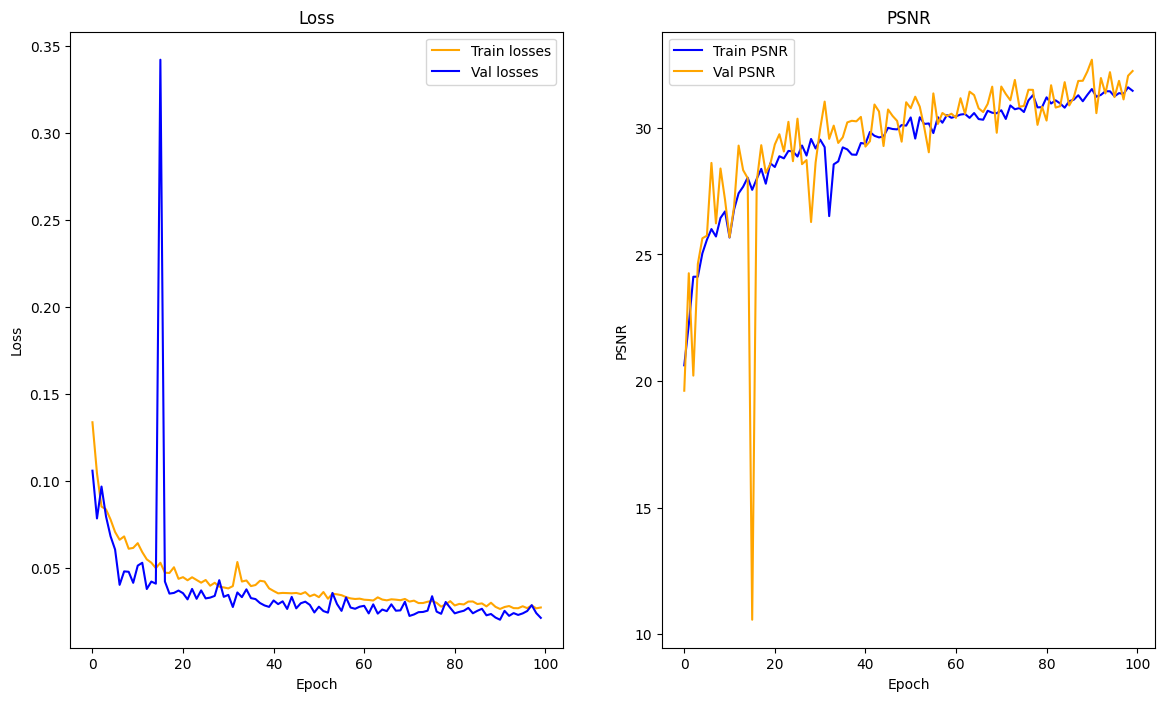

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 8))

train_psnrs_skip = [x.cpu().numpy() for x in train_psnrs_skip]
val_psnrs_skip = [x.cpu().numpy() for x in val_psnrs_skip]

ax[0].plot(train_losses_skip, color='orange', label='Train losses')
ax[0].plot(val_losses_skip, color='blue', label='Val losses')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(train_psnrs_skip, color='blue', label='Train PSNR')
ax[1].plot(val_psnrs_skip, color='orange', label='Val PSNR')
ax[1].set(xlabel='Epoch', ylabel='PSNR')
ax[1].set_title('PSNR')
ax[1].legend()

#### Model UNet without Skip Connection

In [24]:
class FirstFeatureNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class FeatureOutNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlockNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class EncoderNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            ConvBlockNoSkip(in_channels, out_channels)
        )

    def forward(self, x):
        return self.encoder(x)


class DecoderNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_sample = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU()
        )
        self.conv_block = ConvBlockNoSkip(out_channels*2, out_channels)

    def forward(self, x):
        up_sample = self.up_sample(x)
        return self.conv_block(up_sample)


class UNetArchitectureNoSkip(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.first_feature = FirstFeatureNoSkip(in_channels, 64)
        self.conv = ConvBlockNoSkip(64, 64)

        self.encoder1 = EncoderNoSkip(64, 128)
        self.encoder2 = EncoderNoSkip(128, 256)
        self.encoder3 = EncoderNoSkip(256, 512)
        self.encoder4 = EncoderNoSkip(512, 1024)

        self.decoder1 = DecoderNoSkip(1024, 512)
        self.decoder2 = DecoderNoSkip(512, 256)
        self.decoder3 = DecoderNoSkip(256, 128)
        self.decoder4 = DecoderNoSkip(128, 64)

        self.out_conv = FeatureOutNoSkip(64, n_classes)

    def forward(self, x):
        x = self.first_feature(x)
        x = self.conv(x)

        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.encoder4(x)

        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)
        x = self.out_conv(x)

        return x

In [28]:
unet_model_no_skip = UNetArchitectureNoSkip(
    in_channels=3,
    n_classes=3,
)

# run parallel cuda if number of cuda > 1
# if torch.cuda.device_count() > 1:
#     unet_model_no_skip = nn.DataParallel(unet_model_no_skip)
unet_model_no_skip.to(device)

UNetArchitectureNoSkip(
  (first_feature): FirstFeatureNoSkip(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (conv): ConvBlockNoSkip(
    (conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (encoder1): EncoderNoSkip(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlockNoSkip(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size

In [29]:
epochs = 100
lr = 1e-3
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(unet_model_no_skip.parameters(), lr=lr)

In [ ]:
train_losses_skip, train_psnrs_skip, val_losses_skip, val_psnrs_skip = train(
    model=unet_model_no_skip,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    epochs=epochs,
    device=device,
    file_save_model='image_inpainting_no_skip_last.pt'
)

In [ ]:
val_loss_no_skip = evaluate(unet_model, criterion, val_dataloader, device)
test_loss_no_skip = evaluate(unet_model, criterion, test_dataloader, device)
print(f'Valis Loss: {val_loss_no_skip}')
print(f'Test Loss: {test_loss_no_skip}')

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 8))

train_psnrs_skip = [x.cpu().numpy() for x in train_psnrs_skip]
val_psnrs_skip = [x.cpu().numpy() for x in val_psnrs_skip]

ax[0].plot(train_losses_skip, color='orange', label='Train losses')
ax[0].plot(val_losses_skip, color='blue', label='Val losses')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(train_psnrs_skip, color='blue', label='Train PSNR')
ax[1].plot(val_psnrs_skip, color='orange', label='Val PSNR')
ax[1].set(xlabel='Epoch', ylabel='PSNR')
ax[1].set_title('PSNR')
ax[1].legend()